In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # SciPy module that loads mat-files


Neural Networks
===============

Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)``\ that
returns the ``output``.

For example, look at this network that classifies digit images:

![alt text](fig/convnet-mnist.png "Title")

It is a simple feed-forward network. It takes the input, feeds it
through several layers one after the other, and then finally gives the
output.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

Define the network
------------------

Let’s define this network:



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



In [3]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


Let try a random 32x32 input.
Note: expected input size of this net (LeNet) is 32x32. To use this net on
MNIST dataset, please resize the images from the dataset to 32x32.



In [4]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0056, -0.0181, -0.0466,  0.0406,  0.0238,  0.0154,  0.1000,  0.1134,
         -0.0876, -0.0871]], grad_fn=<AddmmBackward>)


Zero the gradient buffers of all parameters and backprops with random
gradients:



In [5]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` only supports mini-batches. The entire ``torch.nn``
    package only supports inputs that are a mini-batch of samples, and not
    a single sample.

    For example, ``nn.Conv2d`` will take in a 4D Tensor of
    ``nSamples x nChannels x Height x Width``.

    If you have a single sample, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
loss functions https://pytorch.org/docs/nn.html#loss-functions under the
nn package .
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:

</div>

In [6]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
print(target)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor([[ 0.5202,  0.9132, -0.9971,  0.5892, -0.8145, -0.2946, -1.6890,  1.2865,
         -1.0162,  0.5626]])
tensor(0.8997, grad_fn=<MseLossBackward>)


Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Tensors in the graph that has ``requires_grad=True``
will have their ``.grad`` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:



In [7]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [8]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0052,  0.0098,  0.0188, -0.0077,  0.0145,  0.0077])


Now, we have seen how to use loss functions.

**Read Later:**

  The neural network package contains various modules and loss functions
  that form the building blocks of deep neural networks. A full list with
  documentation is here https://pytorch.org/docs/nn.

**The only thing left to learn is:**

  - Updating the weights of the network

Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

We can implement this using simple python code:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [9]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update


      Observe how gradient buffers had to be manually set to zero using
      ``optimizer.zero_grad()``. This is because gradients are accumulated
      as explained in `Backprop`_ section.



## Essai sur chiffres MNIST

La rétine de notre réseau fait 32x32

### Chargement et préparation des données

In [10]:
mnist_raw = loadmat('../data/mnist-original.mat')
print(mnist_raw)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014', '__version__': '1.0', '__globals__': [], 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
      dtype=object), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}


In [11]:
data = torch.from_numpy(mnist_raw['data'].transpose()).view((-1,1,28,28))
print(data.shape) # 70000 28x28 images
label = mnist_raw['label'].reshape(-1).astype(int)
print(label.shape)
print(label[:10])

torch.Size([70000, 1, 28, 28])
(70000,)
[0 0 0 0 0 0 0 0 0 0]


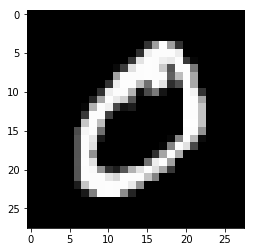

In [12]:
plt.imshow(data[0][0], cmap = plt.cm.gray, clim=(0, 255))

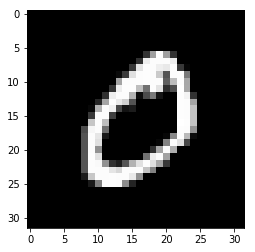

In [13]:
a = nn.functional.pad(data[0][0], (2,2,2,2) )
plt.imshow(a, cmap = plt.cm.gray, clim=(0, 255))

In [14]:
# Normalize: passe de [0, 255] à [0, 1], et ajoute marge de 2 pixels (padding)
def normalise_image(x):
    im32 = nn.functional.pad(x, (2,2,2,2))
    imx = im32.to(torch.float)
    return imx / 255


In [15]:
X = normalise_image(data)

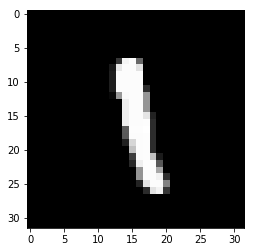

In [16]:
plt.imshow(X[7000][0], cmap = plt.cm.gray, clim=(0, 1))

In [17]:
# Génère les vecteurs de sortie en dimension 10
# "one-hot format"

Y = torch.zeros([len(X), 10], dtype=torch.float)
for i in range(len(X)):
    Y[i][label[i]] = 1.

Y[7000]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
# .randperm génère des permutations:
torch.randperm(10)

tensor([9, 8, 3, 2, 0, 5, 6, 1, 7, 4])

In [19]:
# Mélange les exemples:
indices_permutes = torch.randperm(len(X))
X_perm = X[indices_permutes]
Y_perm = Y[indices_permutes]
print(X_perm.size())

torch.Size([70000, 1, 32, 32])


In [20]:
n_train = (len(X)*2)//3
X_train = X_perm[:n_train]
Y_train = Y_perm[:n_train]

X_test = X_perm[n_train:]
Y_test = Y_perm[n_train:]
print('Learning on', len(X_train), 'examples')
print('Eval     on', len(X_test), 'examples')

Learning on 46666 examples
Eval     on 23334 examples


In [21]:
out = net(X_train[0:1])
print(out)

tensor([[ 0.0139, -0.0130, -0.0168,  0.0030,  0.0263,  0.0134,  0.0374,  0.0968,
         -0.1069, -0.0830]], grad_fn=<AddmmBackward>)


In [22]:
# La classe prédite (0, 1, 2, ..., 9) est donnée par l'indice du max
torch.argmax(out)

tensor(7)

In [23]:
# Calcul de l'erreur de classification
def nb_erreur_classif(Y_true, Y_pred):
    """Nombre d'erreur de classification, sur les 2 tenseurs de sortie "one-hot"
    """
    Y_pred_cls = np.argmax(Y_pred.detach().numpy(), axis=1)
    Y_true_cls = np.argmax(Y_true.detach().numpy(), axis=1)
    return sum(Y_pred_cls != Y_true_cls)

# Essai sur les 1000 premiers:
nb_err = nb_erreur_classif( Y_train[:1000], net(X_train[:1000]) ) 
print("Nombre d'erreurs:", nb_err, "(", nb_err*100/1000., "%)")

Nombre d'erreurs: 893 ( 89.3 %)


### Apprentissage:

In [24]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.8)
batch_size = 1000
num_epochs = 10

losses = []
err_rates = []

In [29]:
# Boucle d'apprentissage

for epoch in range(num_epochs):
    print("starting epoch", epoch)
    for beg_i in range(0, X_train.size(0), batch_size):
        x_batch = X_train[ beg_i:beg_i + batch_size, :]
        y_batch = Y_train[ beg_i:beg_i + batch_size]
        # remise à zéro des gradients
        optimizer.zero_grad()
        # forward:
        outputs = net(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())
        if (beg_i//batch_size) % 10 == 0: 
            # Affiche le coût toutes les 10 mises à jour
            print('loss=', losses[-1])
    
    # Mesure taux erreur après chaque passe (epoch):
    nb_err = nb_erreur_classif( Y_train, net(X_train) ) 
    err_rates.append( nb_err*100/len(Y_train) )
    print("Nombre d'erreurs (training set):", nb_err, "(%3.2g%%)" % err_rates[-1])

print("ok.")

starting epoch 0
loss= 0.013354413211345673
loss= 0.012208815664052963
loss= 0.012675418518483639
loss= 0.011411969549953938
loss= 0.012042001821100712
Nombre d'erreurs (training set): 1817 (3.9%)
starting epoch 1
loss= 0.013113651424646378
loss= 0.0119709437713027
loss= 0.012423180043697357
loss= 0.01117902435362339
loss= 0.011803108267486095
Nombre d'erreurs (training set): 1784 (3.8%)
starting epoch 2
loss= 0.012882324866950512
loss= 0.011746021918952465
loss= 0.012185306288301945
loss= 0.010953949764370918
loss= 0.011580416932702065
Nombre d'erreurs (training set): 1744 (3.7%)
starting epoch 3
loss= 0.012662396766245365
loss= 0.011541372165083885
loss= 0.011956810019910336
loss= 0.010743658058345318
loss= 0.011368295177817345
Nombre d'erreurs (training set): 1718 (3.7%)
starting epoch 4
loss= 0.01245251577347517
loss= 0.0113377645611763
loss= 0.011735593900084496
loss= 0.010537508875131607
loss= 0.011168004013597965
Nombre d'erreurs (training set): 1672 (3.6%)
starting epoch 5
loss

Text(0.5,1,'Training error')

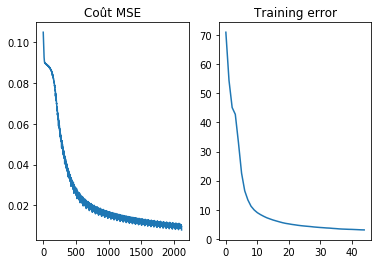

In [30]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(losses)
plt.title('Coût MSE')
plt.subplot(1,2,2)
plt.plot(err_rates)
plt.title('Training error')

## Questions 

1. Tracer, sur les mêmes graphiques que ci-dessus, l'évolution du coût et du taux d'erreur sur l'ensemble de test. Discuter les résultats.

2. Afficher la matrice de confusion (attention à l'encodage de la sortie en "one hot")

3. Reprendre le tout (dans un nouveau notebook copié de celui-ci) avec un coût `CrossEntropyLoss`. (Attention, le codage de la sortie dot alors être le label désiré, un nombre entre 0 et 9).
